In [5]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack
from gensim import parsing

In [3]:
#Instantiate and setup DataFrame
df = pd.read_csv('..\\data\\full_features.csv')
df.set_index('LISTING_ID', inplace = True, drop = True)

In [6]:
preprocessed_text = parsing.preprocess_documents(df.BODY)
preprocessed_text = [' '.join(word) for word in preprocessed_text]
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 2, max_df = 0.7)
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_text)
tfidf_matrix

<126358x20738 sparse matrix of type '<class 'numpy.float64'>'
	with 9238338 stored elements in Compressed Sparse Row format>

In [7]:
features_unscaled = df.drop('BODY', axis = 1)
scaler = StandardScaler()
features = scaler.fit_transform(features_unscaled)

In [8]:
features_unscaled.head()

,Unnamed: 0,PRICE,AREA_SQFT,ALLOWS_CATS,ALLOWS_DOGS,CHAR_COUNT,WORD_COUNT,SENTENCE_COUNT,UNIQUE_COUNT,AVG_WORD_LENGTH,AVG_SENTENCE_LENGTH,UNIQUE_WORD_RATIO
LISTING_ID,,,,,,,,,,,,
7075306172,0,2275,900.0,1.0,0.0,1380,199,6,165,6.934673,33.166667,0.829146
7075321793,1,2350,800.0,1.0,0.0,2180,306,11,226,7.124183,27.818182,0.738562
7075372720,2,2395,875.0,1.0,0.0,1992,289,11,224,6.892734,26.272727,0.775087
7075376264,3,2395,875.0,1.0,0.0,1992,289,11,224,6.892734,26.272727,0.775087
7075380613,4,2450,950.0,1.0,0.0,1966,279,12,211,7.046595,23.250000,0.756272


In [9]:
pd.DataFrame(features).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.732037,0.285777,-0.196376,0.886683,-0.762854,0.552311,0.423130,-0.214663,0.683713,0.674925,0.867024,0.133021
1,-1.732010,0.369994,-0.616577,0.886683,-0.762854,1.680041,1.394159,0.056311,1.545986,0.954204,0.520517,-0.775392
2,-1.731982,0.420524,-0.301426,0.886683,-0.762854,1.415024,1.239883,0.056311,1.517715,0.613119,0.420394,-0.409109
3,-1.731955,0.420524,-0.301426,0.886683,-0.762854,1.415024,1.239883,0.056311,1.517715,0.613119,0.420394,-0.409109
4,-1.731927,0.482284,0.013725,0.886683,-0.762854,1.378373,1.149133,0.110505,1.333952,0.839863,0.224564,-0.597785


In [15]:
type(features)

numpy.ndarray

In [10]:
X_matrix = hstack((tfidf_matrix, features))
X_full = pd.DataFrame.sparse.from_spmatrix(X_matrix)
X_full.shape

(126358, 20750)

In [13]:
components = range(1,25)
var_explained_list = []

for number in components:
    svd = TruncatedSVD(n_components = number)
    svd.fit(X_full)
    var_explained_list.append(svd.explained_variance_ratio_.sum())

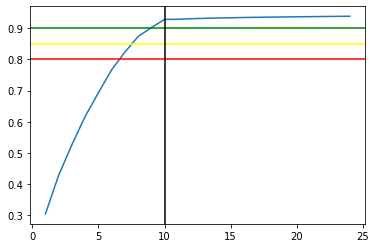

In [16]:
plt.plot(components, var_explained_list)
plt.axhline(0.9, color = 'green')
plt.axhline(0.85, color = 'yellow')
plt.axhline(0.8, color = 'red')
plt.axvline(10, color = 'black')

In [17]:
svd = TruncatedSVD(n_components = 10)
svd.fit(X_full)
var_explained = svd.explained_variance_ratio_.sum()
var_explained

0.9282247441553012

<BarContainer object of 10 artists>

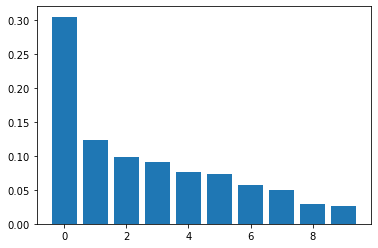

In [18]:
plt.bar(range(len(svd.explained_variance_ratio_)), svd.explained_variance_ratio_)

In [22]:
X = pd.DataFrame(svd.transform(X_full))

In [23]:
X.shape

(126358, 10)

In [25]:
X.index = df.index

In [26]:
X.head()

,0,1,2,3,4,5,6,7,8,9
LISTING_ID,,,,,,,,,,
7075306172,0.917307,0.618685,0.192444,0.099921,0.206868,1.907992,-0.589809,0.425400,0.937936,-0.663455
7075321793,2.725348,0.182099,0.599635,-0.153622,0.743383,1.879798,-0.662512,0.086399,1.158547,-0.440024
7075372720,2.359884,0.124991,0.296978,0.079791,0.647150,1.813236,-0.542062,0.057395,1.010028,-0.771719
7075376264,2.359883,0.124993,0.296990,0.079790,0.647147,1.813213,-0.542055,0.057393,1.010026,-0.771720
7075380613,2.289303,0.146787,0.165366,0.345773,0.798692,1.715030,-0.397729,0.132051,1.198907,-0.484457


In [27]:
X.to_csv('..\\data\\X.csv')